# BATS and TBATS 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (9,6)

In [4]:
# Load data
df = pd.read_csv('data/hourly_traffic.csv', parse_dates=[0], index_col=0)
print(df.shape)
df.head()

(999, 1)


,traffic_volume
date_time,
2016-09-29 17:00:00,5551.0
2016-09-29 18:00:00,4132.0
2016-09-29 19:00:00,3435.0
2016-09-29 20:00:00,2765.0
2016-09-29 21:00:00,2443.0


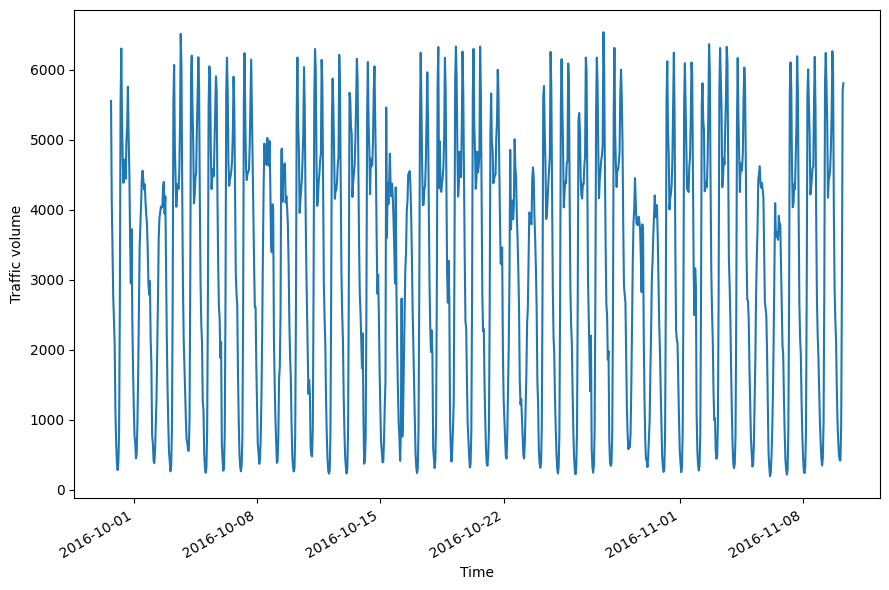

In [5]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.tight_layout()

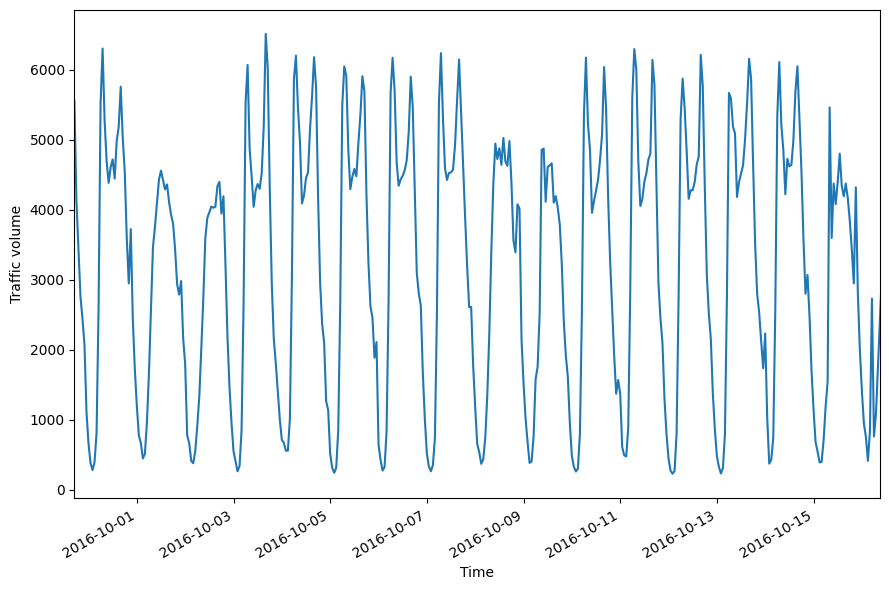

In [6]:
fig, ax = plt.subplots()

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xlim(pd.to_datetime('2016-09-29 17:00:00'), pd.to_datetime('2016-10-16 09:00:00'))

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
# Resample the data at every 4 hours
resampled_df = df.resample('4H').sum()
resampled_df.head()

,traffic_volume
date_time,
2016-09-29 16:00:00,13118.0
2016-09-29 20:00:00,8400.0
2016-09-30 00:00:00,1720.0
2016-09-30 04:00:00,15221.0
2016-09-30 08:00:00,18949.0


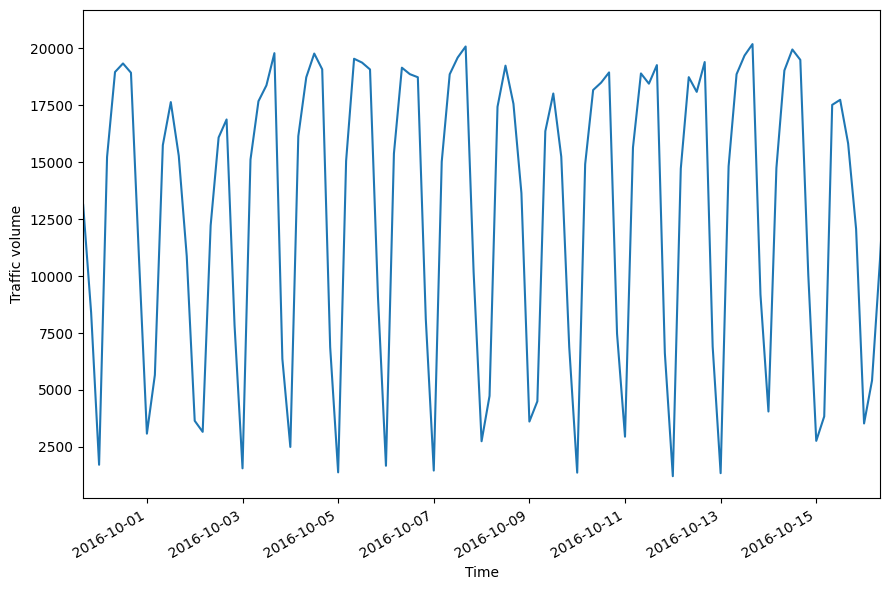

In [8]:
fig, ax = plt.subplots()

ax.plot(resampled_df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xlim(pd.to_datetime('2016-09-29 16:00:00'), pd.to_datetime('2016-10-16 08:00:00'))

fig.autofmt_xdate()
plt.tight_layout()

## BATS 

In [9]:
from sktime.forecasting.bats import BATS

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'BATS':
        # Get predictions from BATS
        pred_BATS = []

        for i in range(train_len, total_len, window):
            # Seasoanl data resampled to 4 hours so 6 x 4 hours in a day and 42 x 4 hours in a week
            forecaster = BATS(use_box_cox = False, use_trend = False, use_damped_trend = False, use_arma_errors = False, sp=[6, 42])
            forecaster.fit(df[:i])
            predictions = forecaster.predict(np.arange(1, window + 1))
            pred_BATS.extend(predictions)

        return pred_BATS

In [10]:
# Train/test split (last 42 time steps for the test set)
train = resampled_df[:-42]
test = resampled_df[-42:]

# Run the predictions
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 6

pred_last_season = rolling_forecast(resampled_df['traffic_volume'], TRAIN_LEN, HORIZON, WINDOW, 'last_season')
pred_BATS = rolling_forecast(resampled_df['traffic_volume'], TRAIN_LEN, HORIZON, WINDOW, 'BATS')

test.loc[:, 'pred_last_season'] = pred_last_season
test.loc[:, 'pred_BATS'] = pred_BATS

test.head()

,traffic_volume,pred_last_season,pred_BATS
date_time,,,
2016-11-03 08:00:00,20055.0,18979.0,19221.105661
2016-11-03 12:00:00,20163.0,18828.0,19293.668155
2016-11-03 16:00:00,20456.0,19852.0,20835.505693
2016-11-03 20:00:00,8195.0,7089.0,8652.655037
2016-11-04 00:00:00,1695.0,2504.0,2462.509601


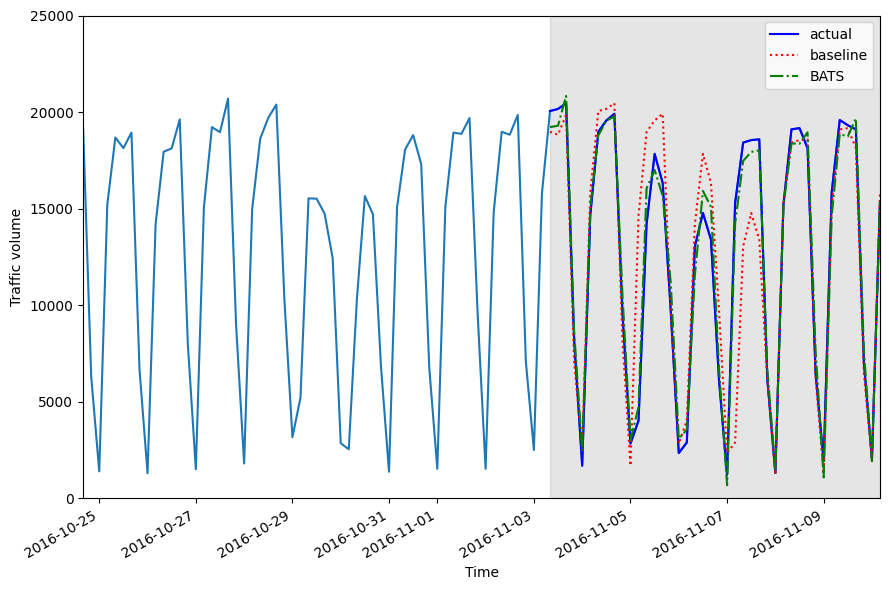

In [12]:
fig, ax = plt.subplots()

ax.plot(resampled_df['traffic_volume'])
ax.plot(test['traffic_volume'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_BATS'], 'g-.', label='BATS')

ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')
ax.axvspan('2016-11-03 08:00:00', '2016-11-10 04:00:00', color='#808080', alpha=0.2)

ax.legend(loc='best')

plt.xlim(pd.to_datetime('2016-10-24 16:00:00'), pd.to_datetime('2016-11-10 04:00:00'))
plt.ylim(0, 25000)

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

In [14]:
mape_baseline = mape(test['traffic_volume'], test['pred_last_season'])
mape_BATS = mape(test['traffic_volume'], test['pred_BATS'])

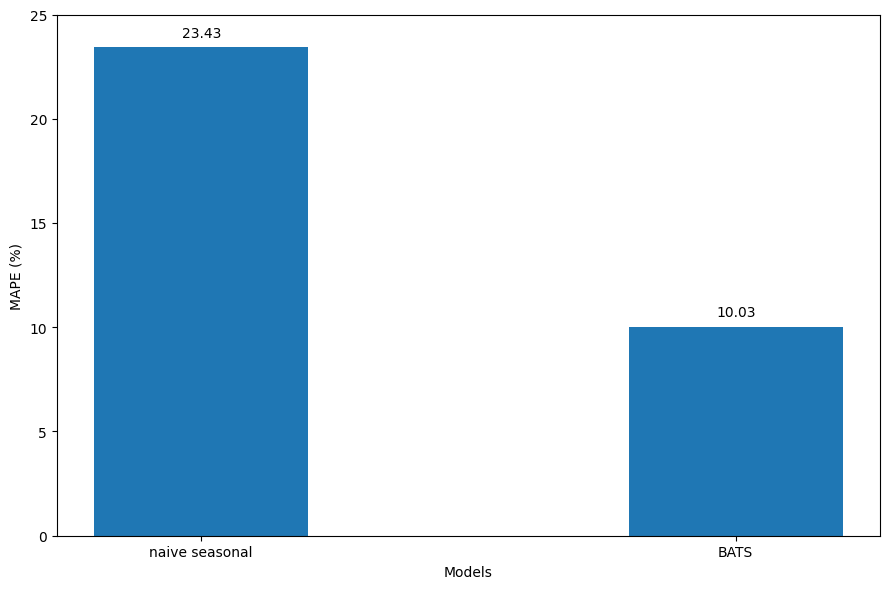

In [15]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'BATS']
y = [mape_baseline, mape_BATS]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 25)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.5, s=str(round(value,2)), ha='center')

plt.tight_layout()

## TBATS 

In [16]:
from sktime.forecasting.tbats import TBATS

def rolling_forecast(df, train_len, horizon, window, method):
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df[:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'BATS':
        pred_BATS = []
        
        for i in range(train_len, total_len, window):
            forecaster = BATS(use_box_cox=False,
                              use_trend=False,
                              use_damped_trend=False,
                              use_arma_errors=False,
                              sp=[6, 42])
            forecaster.fit(df[:i])
            predictions = forecaster.predict(np.arange(1, window+1))
            pred_BATS.extend(predictions)


        return pred_BATS
    
    elif method == 'TBATS':
        # Get predictions from TBATS
        pred_TBATS = []

        for i in range(train_len, total_len, window):

            forecaster = TBATS(use_box_cox = False, use_trend = False, use_damped_trend = False, use_arma_errors = False, sp=[6,42])
            forecaster.fit(df[:i])
            predictions = forecaster.predict(np.arange(1, window+1))
            pred_TBATS.extend(predictions)

        return pred_TBATS

In [17]:
pred_TBATS = rolling_forecast(resampled_df['traffic_volume'], TRAIN_LEN, HORIZON, WINDOW, 'TBATS')

test.loc[:, 'pred_TBATS'] = pred_TBATS

test.head()

,traffic_volume,pred_last_season,pred_BATS,pred_TBATS
date_time,,,,
2016-11-03 08:00:00,20055.0,18979.0,19221.105661,19202.696394
2016-11-03 12:00:00,20163.0,18828.0,19293.668155,19582.487928
2016-11-03 16:00:00,20456.0,19852.0,20835.505693,19073.715050
2016-11-03 20:00:00,8195.0,7089.0,8652.655037,8310.248781
2016-11-04 00:00:00,1695.0,2504.0,2462.509601,2234.812299


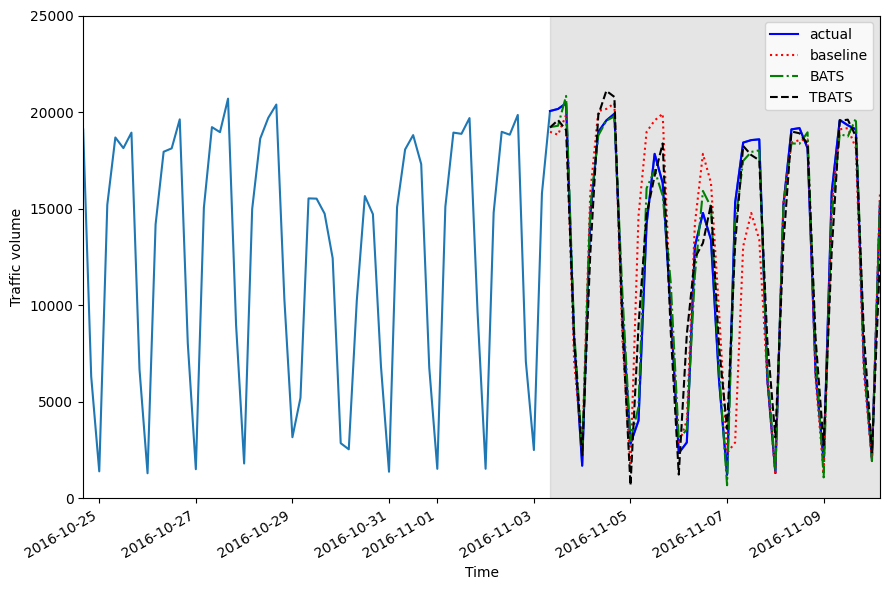

In [20]:
fig, ax = plt.subplots()

ax.plot(resampled_df['traffic_volume'])
ax.plot(test['traffic_volume'], 'b-', label='actual')
ax.plot(test['pred_last_season'], 'r:', label='baseline')
ax.plot(test['pred_BATS'], 'g-.', label='BATS')
ax.plot(test['pred_TBATS'], 'k--', label='TBATS')

ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')
ax.axvspan('2016-11-03 08:00:00', '2016-11-10 04:00:00', color='#808080', alpha=0.2)

ax.legend(loc='best')

plt.xlim(pd.to_datetime('2016-10-24 16:00:00'), pd.to_datetime('2016-11-10 04:00:00'))
plt.ylim(0, 25000)

fig.autofmt_xdate()
plt.tight_layout()

In [21]:
mape_TBATS = mape(test['traffic_volume'], test['pred_TBATS'])

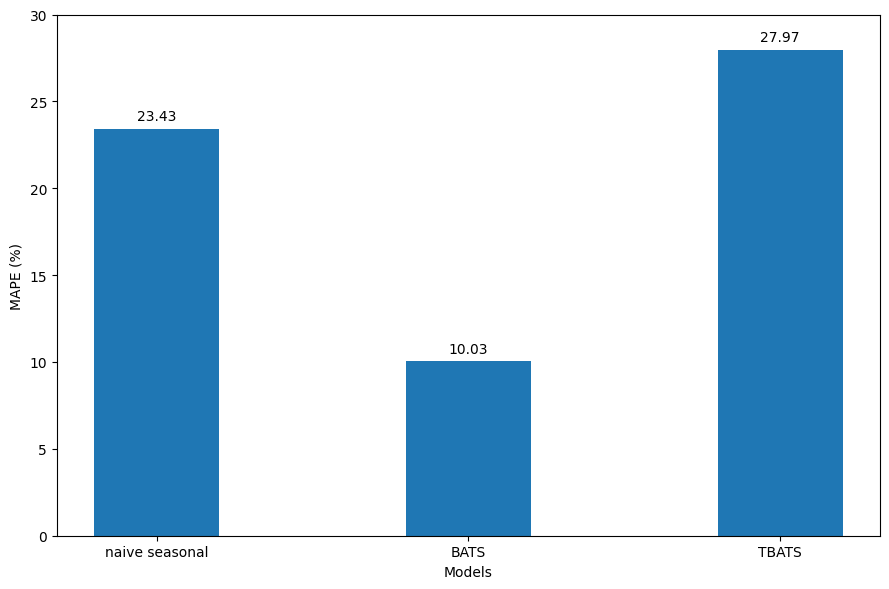

In [22]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'BATS', 'TBATS']
y = [mape_baseline, mape_BATS, mape_TBATS]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 30)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.5, s=str(round(value,2)), ha='center')

plt.tight_layout()